# 📊 PyTorch 심층 선형회귀 예측 (Deep Linear Regression)

이 노트북은 PyTorch를 사용하여 은닉층을 추가한 선형회귀 모델을 구현합니다.

**데이터셋:**
- hour: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
- score: [20, 40, 50, 65, 80, 90, 100, 110, 120, 130]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## 1. 데이터 준비

In [ ]:
# 데이터 정의
hour = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
score = [20, 40, 50, 65, 80, 90, 100, 110, 120, 130]

# PyTorch 텐서로 변환 (2D 형태로)
X = torch.FloatTensor(hour).reshape(-1, 1)
y = torch.FloatTensor(score).reshape(-1, 1)

print(f"입력 데이터 (X): {X.shape} \n {X}")
print(f"출력 데이터 (y): {y.shape} \n {y}")

## 2. 심층 선형회귀 모델 정의 (은닉층 추가)

In [ ]:
class DeepLinearRegressionModel(nn.Module):
    def __init__(self):
        super(DeepLinearRegressionModel, self).__init__()
        # 은닉층 추가: 입력 1 -> 은닉 10 -> 출력 1
        self.layer1 = nn.Linear(1, 10)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# 모델 생성
model = DeepLinearRegressionModel()
print(model)

## 3. 손실 함수 및 옵티마이저 설정

In [ ]:
# 손실 함수: MSE (Mean Squared Error)
criterion = nn.MSELoss()

# 옵티마이저: Adam (학습률=0.01) - SGD보다 수렴 속도가 빠를 수 있음
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("손실 함수: MSE")
print("옵티마이저: Adam (학습률=0.01)")

## 4. 모델 학습

In [ ]:
# 학습 설정
epochs = 2000  # 에포크 수 증가
losses = []

# 학습 시작
for epoch in range(epochs):
    # 순전파
    predictions = model(X)
    loss = criterion(predictions, y)
    
    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 손실 기록
    losses.append(loss.item())
    
    # 200 에포크마다 출력
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("\n학습 완료!")

## 5. 예측 수행

In [ ]:
# 모델을 평가 모드로 전환
model.eval()

# 예측 수행
with torch.no_grad():
    predictions = model(X)

print("시간(hour) | 실제 점수 | 예측 점수")
print("-" * 40)
for i in range(len(hour)):
    print(f"    {hour[i]}      |    {score[i]}     |   {predictions[i].item():.2f}")

# 새로운 값 예측 (예: 11시간)
new_hour = torch.FloatTensor([[11]])
predicted_score = model(new_hour)
print(f"\n11시간 공부 시 예상 점수: {predicted_score.item():.2f}")

## 6. 결과 시각화

In [ ]:
# 그래프 설정
plt.figure(figsize=(12, 5))

# 1. 손실 함수 그래프
plt.subplot(1, 2, 1)
plt.plot(losses, color='#87CEEB')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# 2. 회귀선 그래프
plt.subplot(1, 2, 2)

# 실제 데이터 포인트
plt.scatter(hour, score, color='#FF6B6B', s=100, label='Actual Data', zorder=3)

# 예측 회귀선
with torch.no_grad():
    x_range = torch.linspace(0, 12, 100).reshape(-1, 1)
    y_pred = model(x_range)
    plt.plot(x_range.numpy(), y_pred.numpy(), color='#4ECDC4', linewidth=2, label='Prediction Line')

plt.title('Hour vs Score (Linear Regression)')
plt.xlabel('Study Hour')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

# plt.tight_layout()
plt.show()

## 7. 목표 점수를 위한 공부 시간 예측 및 시각화 (Inverse Prediction)

원하는 점수(Target Score)를 얻기 위해 몇 시간을 공부해야 하는지 역으로 예측하고, 그 결과를 그래프로 시각화합니다.


[역방향 예측] 목표 점수 -> 필요 공부 시간
----------------------------------------
목표 점수 50점 => 약 2.94시간 공부 필요
목표 점수 85점 => 약 5.87시간 공부 필요
목표 점수 100점 => 약 7.14시간 공부 필요
목표 점수 150점 => 약 11.34시간 공부 필요


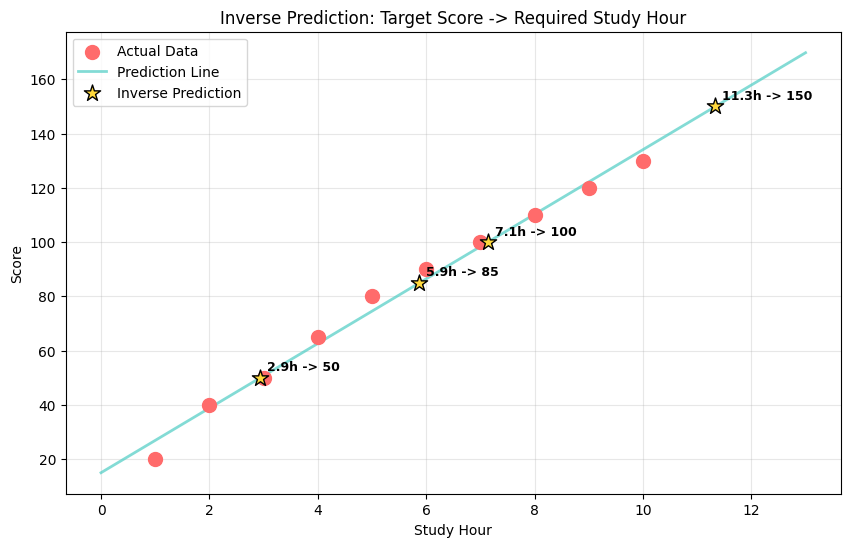

In [37]:
# 원하는 점수를 얻기 위해 필요한 공부 시간 예측 (역추적)
def find_required_hour(target_score, model):
    # 초기 추정치 (예: 5시간)
    required_hour = torch.tensor([5.0], requires_grad=True)
    # 입력값 최적화를 위한 옵티마이저
    optimizer_input = optim.Adam([required_hour], lr=0.1)
    
    for i in range(1000):
        pred = model(required_hour.reshape(1, 1))
        loss = (pred - target_score) ** 2
        
        optimizer_input.zero_grad()
        loss.backward()
        optimizer_input.step()
        
        if loss.item() < 0.0001:
            break
            
    return required_hour.item()

target_scores = [50, 85, 100, 150]
predicted_hours = []

print("\n[역방향 예측] 목표 점수 -> 필요 공부 시간")
print("-" * 40)
for s in target_scores:
    h = find_required_hour(s, model)
    predicted_hours.append(h)
    print(f"목표 점수 {s}점 => 약 {h:.2f}시간 공부 필요")

# 결과 시각화
plt.figure(figsize=(10, 6))

# 1. 실제 데이터
plt.scatter(hour, score, color='#FF6B6B', s=100, label='Actual Data', zorder=3)

# 2. 모델의 예측 회귀선
with torch.no_grad():
    x_range = torch.linspace(0, 13, 100).reshape(-1, 1)
    y_pred = model(x_range)
    plt.plot(x_range.numpy(), y_pred.numpy(), color='#4ECDC4', linewidth=2, label='Prediction Line', alpha=0.7)

# 3. 역방향 예측 결과 (목표 점수 -> 필요 시간)
plt.scatter(predicted_hours, target_scores, color='#FFD93D', s=150, marker='*', label='Inverse Prediction', zorder=4, edgecolors='black')

# 텍스트 주석 추가
for h, s in zip(predicted_hours, target_scores):
    plt.annotate(f"{h:.1f}h -> {s}", (h, s), xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.title('Inverse Prediction: Target Score -> Required Study Hour')
plt.xlabel('Study Hour')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()